In [1]:
!pip install numpy
!pip install matplotlib
!pip install scikit-image
!pip install pillow
!pip install opencv-python
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from typing import Callable
import os
from datetime import datetime
from enum import Enum
import random
from skimage.color import rgb2gray, rgb2hsv
from skimage import filters
from skimage import segmentation
from skimage.morphology import remove_small_holes, remove_small_objects
import cv2 as cv

In [3]:
import platform

# Get os name
os_name = platform.system().lower()
num_workers = 8

# OS X
if 'darwin' in os_name:
    print("Detected OS X")
    %pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.1
# Linux 
elif 'linux' in os_name:
    print("Detected Linux")
    %pip install torch==1.8.1 torchvision==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
# Windows 
else:
    print("Detected Windows")
    num_workers = 0  # Hard fix for Windows users
    %pip install torch==1.8.1 torchvision==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html


Detected Windows
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [4]:
from PIL import Image
from torchvision import transforms
import torch

In [5]:
class ImageType(Enum):
    NEUTRAL = "1. neutral_bg"
    NOISY = "2. noisy_bg"
    HAND = "3. hand"
    NEUTRAL_OOD = "4. neutral_bg_outliers"
    NOISY_OOD = "5. noisy_bg_outliers"
    HAND_OOD = "6. hand_outliers"
    
def loadImageOfType(type: ImageType, downsample: int = 1, grayscale: bool = False):
    # directory = f"./data/train/{type}"
    directory = os.path.join(".", "data", "train", type.value)
    images = os.listdir(directory)
    img = np.array(Image.open(os.path.join(directory, random.choice(images)))) 
    if downsample > 1:
        img = img[::downsample, ::downsample, :]
    if grayscale:
        img = (rgb2gray(img)*255).astype(np.uint8)
        
    # img = filters.sobel(img)
    
    return img
        


## Preprocessing

In [6]:
def filter_circles(circle_array):
    # print(circle_array)
    # Convert the array to a NumPy array
    
    # Find unique center coordinates
    unique_centers, unique_indices = np.unique(circle_array[:, :2], axis=0, return_index=True)
    # print(unique_indices)
    
    # Get the indices of circles with largest radius for each unique center
    largest_circles = []
    for center in unique_centers:
      largest_circle = np.array((center[0], center[1], 0))
      for j in range(len(circle_array)):
        circle = circle_array[j]
        if (circle[0] == center[0] and circle[1]==center[1] and circle[2] > largest_circle[2]):
          largest_circle[2] = circle[2] 
      largest_circles.append(largest_circle)
  
    # print(largest_circles)
               
      

    # # Convert the list of indices to a NumPy array
    # max_radius_indices = np.array(max_radius_indices)
    # print(max_radius_indices)
    
    return np.array(largest_circles)

In [7]:
# the input is a cv image so x and y are swapped
def extract_circles_images(x, y, r, img):
    factor = r
    left = x - factor
    right = x + factor
    up = y - factor
    bottom = y + factor
    return img[up:bottom, left:right, :]

In [8]:
def find_circles(path, debug = False):
    img = cv.imread(path)
    down = 3
    size = (int(img.shape[1]/down), int(img.shape[0]/down))
    img = cv.resize(img, size, interpolation=cv.INTER_LINEAR)

    output = img.copy()
    output[:, :, 0] = img[:, :, 2]
    output[:, :, 2] = img[:, :, 0]
    img[:, :, 2] = 0

    gray = cv.blur(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (8, 8))

    # detect circles in the image
    circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=50, maxRadius=200, param1=5, param2=0.6)
    # ensure at least some circles were found
    circles_imgs = []
    if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        circles = filter_circles(circles)
        print(f"detected {len(circles)} circles")
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            # cv.circle(output, (x, y), r, (0, 255, 0), 4)
            # cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 255, 0), -1)
            new_circle = extract_circles_images(x, y, r, output)
            circles_imgs.append(new_circle)
            if debug:
                plt.imshow(new_circle)
                plt.show()
            # circles_imgs.append(extract_circles_images(x, y, r, output))
    
        # show the output image
    if debug:
        plt.imshow(output)
        plt.show()
    return circles_imgs

In [9]:
def get_training_data_paths():
    training_paths = []
    base_dir = "./data/train/"
    for d in os.listdir(base_dir):
        training_dir = f"{base_dir}/{d}"
        for path in os.listdir(training_dir):
            file_path = f"{training_dir}/{path}"
            training_paths.append(file_path)
            # print(file_path)
    return training_paths
        
# get_training_data_paths()

In [10]:
def get_label_for_image(path):
    filename = path.split("/")[-1].split(".")[0]

    data = np.genfromtxt('./data/train_labels.csv', delimiter=',', dtype=str)

# Assume the first column contains the strings you want to search through
    first_column = data[:, 0]

    # Find the index of the first entry that matches your string
    index = np.where(first_column == filename)[0]
    
    if index.size > 0:
        # print(f"The first entry matching '{filename}' is at index {index[0]}.")
        #we add 0 in order to account for non coins
        label_vector = np.append(data[index[0]][1:], 0)
        # print(label_vector)
        return torch.from_numpy(label_vector.astype(np.float32))
        # You can access the corresponding row using data[index[0]]
    else:
        # print(f"No entry matching '{filename}' found.")
        return torch.zeros(0)


detected 5 circles


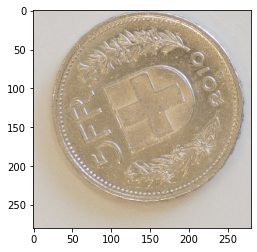

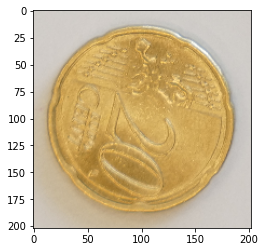

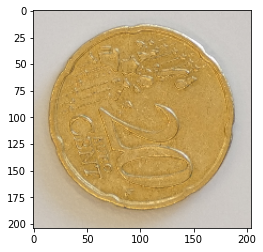

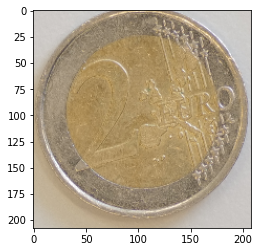

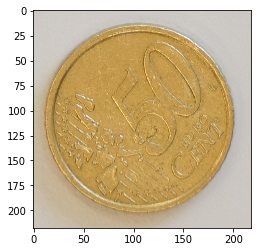

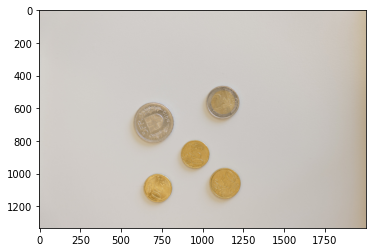

In [11]:
# d = "./data/train/1. neutral_bg//"
# d = "./data/train/2. noisy_bg///"
# d = "./data/train/3. hand///"
d = "./data/train/5. noisy_bg_outliers/"
# d = "./data/train/6. hand_outliers///"
# d = "./data/test//"
# for f in os.listdir(d):

paths = get_training_data_paths()
p = paths[0]
if get_label_for_image(p).shape[0] == 0:
    print("wrong filename")

circles = find_circles(paths[0], debug=True)
# for path in get_training_data_paths():
# img = cv.imread(f"{d}/{f}")[::3, ::3].astype(np.uint8)
# img[:, :, 1] = 0



In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
def extract_features(input_image):
    # or any of these variants
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
    model.eval()
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    input_image = Image.fromarray(input_image)
    # input_image.show()
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
   
    input_batch = input_batch.to(device)
    feature_extractor.to(device)

    with torch.no_grad():
        features = feature_extractor(input_batch)
    # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
    # print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    # probabilities = torch.nn.functional.softmax(output[0], dim=0)
    features = torch.flatten(features)
    # print(features.size())
    return features




Using cuda for inference


Using cache found in C:\Users\iab_b/.cache\torch\hub\pytorch_vision_v0.10.0


In [13]:
for circle in circles:
    print(extract_features(circle))

tensor([0.7524, 0.3154, 2.1971,  ..., 0.3465, 0.0049, 0.8135], device='cuda:0')
tensor([0.2689, 0.0256, 2.4720,  ..., 0.7673, 0.0099, 0.3627], device='cuda:0')
tensor([0.1559, 0.0420, 2.3264,  ..., 0.3951, 0.0000, 0.1190], device='cuda:0')
tensor([0.4552, 0.0604, 2.5847,  ..., 0.5366, 0.0085, 0.4297], device='cuda:0')
tensor([0.2412, 0.0976, 1.9263,  ..., 0.6483, 0.0145, 0.4172], device='cuda:0')


In [14]:
def get_test_data_paths():
    test_paths = []
    base_dir = "./data/test/"
    for path in os.listdir(base_dir):
        file_path = f"{base_dir}/{path}"
        test_paths.append(file_path)
            # print(file_path)
    return test_paths



## Training on individual coin

In [15]:
linear = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    # # torch.nn.Linear(in_features = 1250, out_features = 512), 
    # torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 17), 
    # torch.nn.Softmax(dim=1) 
)

linear = linear.to(device)


In [16]:
import random
from PIL import Image as im 
class_names = ["chf_5", "chf_2", "chf_1", "chf_0.5", "chf_0.2", "chf_0.1", "chf_0.05", "eur_2", "eur_1", "eur_0.5", "eur_0.2", "eur_0.1", "eur_0.05", "eur_0.02", "eur_0.01", "ood", "bg"]

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(linear.parameters(), lr=1e-3)

for i in range(5000):
    
    """
    Selecting image at random
    """
    index = np.random.randint(0, 17)
    class_nb = len(class_names)
    # target = torch.zeros(class_nb).to(device)
    # target[index] = 1
    target = torch.tensor([index]).to(device)
    # target[0] = index
    

    labeled_coins_dir = "./data/labeled_coins/"
    selected_dir = f"{labeled_coins_dir}{class_names[index]}"
    files = os.listdir(selected_dir)
    selected_file = random.choice(files)
    selected_file_path = f"{selected_dir}/{selected_file}"
    # print(selected_file_path)
    
    coin = im.open(selected_file_path)
    degrees = random.randint(0, 360)
    coin = coin.rotate(degrees, resample=Image.BICUBIC)
    # coin.show()
    
    """
    extracting features + training
    """

    optimizer.zero_grad()
    x = extract_features(np.array(coin))
    x = torch.unsqueeze(x, 0)

    pred = linear(x)
    # print(pred)
    # print(target)
    loss = criterion(pred, target) 
    loss.backward() 
    if i %10 == 0:
        print(f"loss at {i} - {loss}")
    optimizer.step() 



loss at 0 - 2.946108102798462
loss at 10 - 3.6791770458221436
loss at 20 - 2.6603896617889404
loss at 30 - 3.9568533897399902
loss at 40 - 2.2902886867523193
loss at 50 - 3.4872403144836426
loss at 60 - 2.3892569541931152
loss at 70 - 3.5701088905334473
loss at 80 - 2.593648910522461
loss at 90 - 2.8795552253723145
loss at 100 - 3.178128242492676
loss at 110 - 3.15990948677063
loss at 120 - 3.114711046218872
loss at 130 - 2.700063467025757
loss at 140 - 2.7941079139709473
loss at 150 - 2.4248807430267334
loss at 160 - 2.919328451156616
loss at 170 - 2.6606078147888184
loss at 180 - 2.582988977432251
loss at 190 - 2.2470614910125732
loss at 200 - 2.9801197052001953
loss at 210 - 4.002960681915283
loss at 220 - 2.592707872390747
loss at 230 - 2.9790053367614746
loss at 240 - 2.1414248943328857
loss at 250 - 2.2006239891052246
loss at 260 - 1.9979948997497559
loss at 270 - 3.084660053253174
loss at 280 - 1.8170855045318604
loss at 290 - 3.388408660888672
loss at 300 - 2.8554625511169434
l

In [ ]:
sum(p.numel() for p in model.parameters())

In [17]:
csv_header = "id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD"



In [18]:
def path_to_filename(path):
    return path.split("/")[-1].split(".")[0]

## Testing

In [ ]:
def predict(path):
    with torch.no_grad():
        linear.eval()

        circles = find_circles(path)
        pred_vector = np.zeros(16)
        for circle in circles:
            features = extract_features(circle)
            features = torch.unsqueeze(x, 0)
            pred_test = linear(features).flatten()
            pred_class = torch.argmax(pred_test)
            if pred_class == 16: continue
            pred_vector[pred_class] += 1

    return pred_vector
        

In [20]:
index = np.random.randint(0, 17)
csv_file = csv_header
csv_file += "\n"
with torch.no_grad():
# index = 16
    linear.eval()

    # labeled_coins_dir = "./data/labeled_coins/"
    # selected_dir = f"{labeled_coins_dir}{class_names[index]}"
    # files = os.listdir(selected_dir)
    # selected_file = random.choice(files)
    # selected_file_path = f"{selected_dir}/{selected_file}"
    # print(selected_file_path)

    for i, path in enumerate(get_test_data_paths()):
        print(i)
    
        # path = "./data/test/L0000113.JPG"
        coins = find_circles(path)
        # coins = find_circles("./data/train/1. neutral_bg/L1010277.JPG")
        
        p = np.zeros(16, dtype=np.uint8)
        for coin in coins:
            shape = coin.shape
            if shape[0] <10 or shape[1]<10: continue
            # print(coin.shape)
        
            
            
            # coin = np.array(im.open(selected_file_path))
            # coin.show()


            x = extract_features(coin)
            # print(x)
            x = torch.unsqueeze(x, 0)

            pred_test = linear(x).flatten()
            # print(pred_test)
            pred_class = torch.argmax(pred_test)
            if pred_class == 16: continue
            p[pred_class] += 1
        # print(f"pred {pred_class}")
        # print(f"target: {index}")
        
        # print(p)
        p_string = np.array2string(p, separator=', ', precision=0).replace("[", "").replace("]", "")
        csv_row = f"{path_to_filename(path)},{p_string}"
        # print(csv_row)
        csv_file += csv_row
        csv_file += "\n"

with open('./data/submission.csv', 'w') as file:
    # Write a string to the file
    file.write(csv_file)
    
# print(csv_row)


0
detected 4 circles
1
detected 10 circles
2
detected 4 circles
3
detected 8 circles
4
detected 6 circles
5
detected 8 circles
6
detected 8 circles
7
detected 6 circles
8
detected 4 circles
9
detected 5 circles
10
detected 5 circles
11
detected 8 circles
12
detected 6 circles
13
detected 5 circles
14
detected 5 circles
15
detected 5 circles
16
detected 5 circles
17
detected 7 circles
18
detected 5 circles
19
detected 3 circles
20
detected 6 circles
21
detected 3 circles
22
detected 6 circles
23
detected 11 circles
24
detected 5 circles
25
detected 3 circles
26
detected 6 circles
27
detected 6 circles
28
detected 1 circles
29
detected 5 circles
30
detected 8 circles
31
detected 1 circles
32
detected 3 circles
33
detected 9 circles
34
detected 4 circles
35
detected 4 circles
36
detected 4 circles
37
detected 4 circles
38
detected 3 circles
39
detected 4 circles
40
detected 3 circles
41
detected 7 circles
42
detected 6 circles
43
detected 4 circles
44
detected 4 circles
45
detected 9 circ

In [ ]:
test_paths = get_test_data_paths()
# path = test_paths[3]


# csv_row = f"{path_to_filename(path),{",".join(pred_vector)}}"
# print(csv_row)
for path in test_paths:
    pred_vector = predict(path)

    print(pred_vector)

## extracting all coins

In [ ]:
from PIL import Image as im 
paths = get_training_data_paths()
print(len(paths))

# for path in paths:
for path in paths:
    circles =find_circles(path)
    for i, circle in enumerate(circles):
        file_number = path.split("/")[-1].split(".")[0]
        print(file_number)
        im.fromarray(circle).save(f"./data/unlabeled_coins/{file_number}_{i}.jpg")
    
